In [1]:
import numpy as np
import matplotlib.pyplot as plt
from velocity_functions import *
from scipy.integrate import odeint
%matplotlib inline

radius  = {'RBC':3.75e-6,'WBC':6.25e-6,'plate':1.19e-6,'bac':2.5e-6} # radius in meters
density = {'RBC':1093,   'WBC':1066,   'plate':1053,   'bac': 1025 } # density in kg/m3
sedcoef = {'RBC':12e-7,  'WBC':1.2e-7, 'plate':0.032e-7} # Sedimentation coefficient in s (Van Wie)
viscosity = {'plas':0.0026} # viscosity of plasma in kg/m s

# Velocity and Integration schemes
The current scheme integrates a 1D scalar conservation law using zero flux B.C. at both walls.
I want to put in stokes velocity and the right dimensions
### Next steps:
> plot RBC trajectory and compare to data  
> Figure out slip velocities

In [2]:
def get_c(α,r,cell_params,mode='RZ'): #r is a stand-in value
    RPM,D,density = cell_params
    
    # Evaluate scalar stokes velocity as f(RPM,r,D)
    c_max = stokes(RPM,r,D,density)
    hsc = 1.0
    
    if mode == "RZ":
        hsc = (1-α)**2 # Richardson-zaki correlation
        
    return c_max*hsc

def bc(inside,left_edge,right_edge):
    output       = np.zeros(ngrd+2)
    output[0]    = left_edge
    output[-1]   = right_edge
    output[1:-1] = inside
    return output

def godunov(α,t,r,cell_params):
    α_bc       = np.zeros(ngrd+2)
    α_bc[-1]   = 1.0
    α_bc[1:-1] = α

    r_bc       = np.zeros(ngrd+2)
    r_bc[0]    = r1-Δx
    r_bc[-1]   = r2+Δx
    r_bc[1:-1] = r
    
    # evaluate fluxes at each cell and initialize cell interfaces
    q = α_bc*get_c(α_bc,r_bc,cell_params)
    qf = np.zeros(ngrdf)
    
    # apply Godunov flux at each cell interface
    for i in range(ngrdf):
        if α_bc[i] >= α_bc[i+1]:
            qf[i] = max(q[i],q[i+1])
        elif α_bc[i] <= 0 and 0 <= α_bc[i+1]:
            qf[i] = 0
        else:
            qf[i] = min(q[i],q[i+1])
    
    # apply upwinding scheme with the godunov interface fluxes...
    dαdt = 1/Δx*(qf[:-1]-qf[1:])
    return dαdt

spin = (3000,radius['RBC'],density['RBC'])

ngrd = 250
r1   = 0.04 # m
r2   = 0.06 # m
tend = 60
ntimes = 30

times = np.linspace(0,tend,ntimes)
Δt    = tend/ntimes
ngrdf = ngrd+1
Δx    = (r2-r1)/ngrd
xf    = np.linspace(r1,r2,ngrdf)
x     = (xf[1:] + xf[:-1])/2

α0  = np.ones(ngrd)*0.35
αall,diag = odeint(godunov, α0, times,args=(x,spin),full_output=1)

C:\Users\cdhig\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


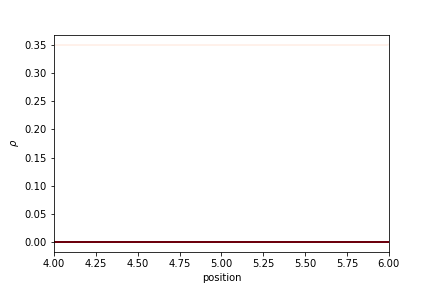

In [3]:
%matplotlib notebook
fig = plt.figure()
fig.figsize=(10,10)

color = plt.get_cmap('Reds')
colors = iter(color(np.linspace(0.0,1,ntimes)))
for j in range(ntimes):
    plt.plot(x*100,αall[j,:],color=next(colors))

plt.xlabel('position')
plt.ylabel(r'$\rho$')
plt.xlim([r1*100,r2*100]);
# plt.ylim([0,1]);
plt.show()

### Checking stability criteria and stuff

In [ ]:
v = stokes(3000,0.05,radius['RBC'],density['RBC'])
c = Δt*v/Δx
c,v

In [ ]:
ρs = np.linspace(0,1)
plt.plot(ρs,get_c(ρs,0.04,spin,mode='RZ'))
plt.show()